<a href="https://colab.research.google.com/github/noahgift/managed_ml_systems_and_iot/blob/master/TensorFlow_RussianDolls.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TensorFlow Russian Dolls




![wikipedia_commons](https://upload.wikimedia.org/wikipedia/commons/thumb/0/0a/Russian_Dolls.jpg/640px-Russian_Dolls.jpg)

[*source:  wikipedia*](https://upload.wikimedia.org/wikipedia/commons/thumb/0/0a/Russian_Dolls.jpg/640px-Russian_Dolls.jpg)

A *crash course* involving several layers of abstraction with [TensorFlow](https://www.tensorflow.org/)

## TensorFlow

### TensorFlow Hello World

References

*  [Official Hello World Example]( https://colab.research.google.com/notebooks/welcome.ipynb#scrollTo=oYZkU7ZN3CL0)
*  Adds two matrices


In [2]:
import tensorflow as tf
input1 = tf.ones((2, 3))
input2 = tf.reshape(tf.range(1, 7, dtype=tf.float32), (2, 3))

print("Two Tensor Flow Matrices with shape:")
print(input1.shape)
print(input2.shape)

Two Tensor Flow Matrices with shape:
(2, 3)
(2, 3)


In [3]:
output = input1 + input2
with tf.Session():
  result = output.eval()

print(f"Type of result:  {type(result)}\n")
print("Result of addition of two Matrics:")
result


Type of result:  <class 'numpy.ndarray'>

Result of addition of two Matrics:


array([[2., 3., 4.],
       [5., 6., 7.]], dtype=float32)

### Tensorflow Linear Regression (Project)

Based *on official Google Tutorial [here](https://developers.google.com/machine-learning/crash-course/first-steps-with-tensorflow/programming-exercises)*

**Learning Objectives:**
  * Learn fundamental TensorFlow concepts
  * Use the `LinearRegressor` class in TensorFlow to predict median housing price, at the granularity of city blocks, based on one input feature
  * Evaluate the accuracy of a model's predictions using Root Mean Squared Error (RMSE)
  * Improve the accuracy of a model by tuning its hyperparameters

The [data](https://developers.google.com/machine-learning/crash-course/california-housing-data-description) is based on 1990 census data from California.

#### Setup
In this first cell, we'll load the necessary libraries.

In [0]:
import math

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
import tensorflow as tf
from tensorflow.python.data import Dataset

tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format

Next, we'll load our data set.

In [0]:
california_housing_dataframe = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_train.csv", sep=",")

We'll randomize the data, just to be sure not to get any pathological ordering effects that might harm the performance of Stochastic Gradient Descent. Additionally, we'll scale `median_house_value` to be in units of thousands, so it can be learned a little more easily with learning rates in a range that we usually use.

In [6]:
california_housing_dataframe = california_housing_dataframe.reindex(
    np.random.permutation(california_housing_dataframe.index))
california_housing_dataframe["median_house_value"] /= 1000.0
california_housing_dataframe

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
14948,-122.2,37.5,29.0,1617.0,235.0,758.0,246.0,7.8,469.9
6812,-118.3,34.1,26.0,2107.0,757.0,2660.0,740.0,2.3,282.3
14564,-122.2,37.9,32.0,1779.0,241.0,721.0,258.0,8.8,434.5
9273,-119.1,35.4,37.0,2044.0,394.0,894.0,359.0,2.9,82.8
7940,-118.4,34.3,38.0,858.0,203.0,1250.0,204.0,2.9,137.9
...,...,...,...,...,...,...,...,...,...
6189,-118.2,34.1,8.0,1204.0,552.0,1074.0,517.0,1.0,87.5
6963,-118.3,34.0,44.0,1555.0,324.0,931.0,265.0,1.5,105.8
1799,-117.3,33.0,9.0,4632.0,759.0,1724.0,685.0,6.4,369.8
1870,-117.3,34.2,26.0,2469.0,532.0,1068.0,501.0,2.0,122.1


#### Examine the Data

It's a good idea to get to know your data a little bit before you work with it.

We'll print out a quick summary of a few useful statistics on each column: count of examples, mean, standard deviation, max, min, and various quantiles.

In [7]:
california_housing_dataframe.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0
mean,-119.6,35.6,28.6,2643.7,539.4,1429.6,501.2,3.9,207.3
std,2.0,2.1,12.6,2179.9,421.5,1147.9,384.5,1.9,116.0
min,-124.3,32.5,1.0,2.0,1.0,3.0,1.0,0.5,15.0
25%,-121.8,33.9,18.0,1462.0,297.0,790.0,282.0,2.6,119.4
50%,-118.5,34.2,29.0,2127.0,434.0,1167.0,409.0,3.5,180.4
75%,-118.0,37.7,37.0,3151.2,648.2,1721.0,605.2,4.8,265.0
max,-114.3,42.0,52.0,37937.0,6445.0,35682.0,6082.0,15.0,500.0


#### Build the First Model

In this exercise, we'll try to predict `median_house_value`, which will be our label (sometimes also called a target). We'll use `total_rooms` as our input feature.

**NOTE:** Our data is at the city block level, so this feature represents the total number of rooms in that block.

To train our model, we'll use the [LinearRegressor](https://www.tensorflow.org/api_docs/python/tf/estimator/LinearRegressor) interface provided by the TensorFlow [Estimator](https://www.tensorflow.org/get_started/estimator) API. This API takes care of a lot of the low-level model plumbing, and exposes convenient methods for performing model training, evaluation, and inference.

##### Step 1: Define Features and Configure Feature Columns

In order to import our training data into TensorFlow, we need to specify what type of data each feature contains. There are two main types of data we'll use in this and future exercises:

* **Categorical Data**: Data that is textual. In this exercise, our housing data set does not contain any categorical features, but examples you might see would be the home style, the words in a real-estate ad.

* **Numerical Data**: Data that is a number (integer or float) and that you want to treat as a number. As we will discuss more later sometimes you might want to treat numerical data (e.g., a postal code) as if it were categorical.

In TensorFlow, we indicate a feature's data type using a construct called a **feature column**. Feature columns store only a description of the feature data; they do not contain the feature data itself.

To start, we're going to use just one numeric input feature, `total_rooms`. The following code pulls the `total_rooms` data from our `california_housing_dataframe` and defines the feature column using `numeric_column`, which specifies its data is numeric:

In [0]:
# Define the input feature: total_rooms.
my_feature = california_housing_dataframe[["total_rooms"]]

# Configure a numeric feature column for total_rooms.
feature_columns = [tf.feature_column.numeric_column("total_rooms")]

**NOTE:** The shape of our `total_rooms` data is a one-dimensional array (a list of the total number of rooms for each block). This is the default shape for `numeric_column`, so we don't have to pass it as an argument.

##### Step 2: Define the Target

Next, we'll define our target, which is `median_house_value`. Again, we can pull it from our `california_housing_dataframe`:

In [0]:
# Define the label.
targets = california_housing_dataframe["median_house_value"]

##### Step 3: Configure the LinearRegressor

Next, we'll configure a linear regression model using LinearRegressor. We'll train this model using the `GradientDescentOptimizer`, which implements Mini-Batch Stochastic Gradient Descent (SGD). The `learning_rate` argument controls the size of the gradient step.

**NOTE:** To be safe, we also apply [gradient clipping](https://developers.google.com/machine-learning/glossary/#gradient_clipping) to our optimizer via `clip_gradients_by_norm`. Gradient clipping ensures the magnitude of the gradients do not become too large during training, which can cause gradient descent to fail. 

In [10]:
# Use gradient descent as the optimizer for training the model.
my_optimizer=tf.train.GradientDescentOptimizer(learning_rate=0.0000001)
my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)

# Configure the linear regression model with our feature columns and optimizer.
# Set a learning rate of 0.0000001 for Gradient Descent.
linear_regressor = tf.estimator.LinearRegressor(
    feature_columns=feature_columns,
    optimizer=my_optimizer
)


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



##### Step 4: Define the Input Function

To import our California housing data into our `LinearRegressor`, we need to define an input function, which instructs TensorFlow how to preprocess
the data, as well as how to batch, shuffle, and repeat it during model training.

First, we'll convert our *pandas* feature data into a dict of NumPy arrays. We can then use the TensorFlow [Dataset API](https://www.tensorflow.org/programmers_guide/datasets) to construct a dataset object from our data, and then break
our data into batches of `batch_size`, to be repeated for the specified number of epochs (num_epochs). 

**NOTE:** When the default value of `num_epochs=None` is passed to `repeat()`, the input data will be repeated indefinitely.

Next, if `shuffle` is set to `True`, we'll shuffle the data so that it's passed to the model randomly during training. The `buffer_size` argument specifies
the size of the dataset from which `shuffle` will randomly sample.

Finally, our input function constructs an iterator for the dataset and returns the next batch of data to the LinearRegressor.

In [0]:
def my_input_fn(features, targets, batch_size=1, shuffle=True, num_epochs=None):
    """Trains a linear regression model of one feature.
  
    Args:
      features: pandas DataFrame of features
      targets: pandas DataFrame of targets
      batch_size: Size of batches to be passed to the model
      shuffle: True or False. Whether to shuffle the data.
      num_epochs: Number of epochs for which data should be repeated. None = repeat indefinitely
    Returns:
      Tuple of (features, labels) for next data batch
    """
  
    # Convert pandas data into a dict of np arrays.
    features = {key:np.array(value) for key,value in dict(features).items()}                                           
 
    # Construct a dataset, and configure batching/repeating.
    ds = Dataset.from_tensor_slices((features,targets)) # warning: 2GB limit
    ds = ds.batch(batch_size).repeat(num_epochs)
    
    # Shuffle the data, if specified.
    if shuffle:
      ds = ds.shuffle(buffer_size=10000)
    
    # Return the next batch of data.
    features, labels = ds.make_one_shot_iterator().get_next()
    return features, labels

**NOTE:** We'll continue to use this same input function in later exercises. For more
detailed documentation of input functions and the `Dataset` API, see the [TensorFlow Programmer's Guide](https://www.tensorflow.org/programmers_guide/datasets).

##### Step 5: Train the Model

We can now call `train()` on our `linear_regressor` to train the model. We'll wrap `my_input_fn` in a `lambda`
so we can pass in `my_feature` and `target` as arguments (see this [TensorFlow input function tutorial](https://www.tensorflow.org/get_started/input_fn#passing_input_fn_data_to_your_model) for more details), and to start, we'll
train for 100 steps.

In [0]:
_ = linear_regressor.train(
    input_fn = lambda:my_input_fn(my_feature, targets),
    steps=100
)

##### Step 6: Evaluate the Model

Let's make predictions on that training data, to see how well our model fit it during training.

**NOTE:** Training error measures how well your model fits the training data, but it **_does not_** measure how well your model **_generalizes to new data_**. In later exercises, you'll explore how to split your data to evaluate your model's ability to generalize.


In [13]:
# Create an input function for predictions.
# Note: Since we're making just one prediction for each example, we don't 
# need to repeat or shuffle the data here.
prediction_input_fn =lambda: my_input_fn(my_feature, targets, num_epochs=1, shuffle=False)

# Call predict() on the linear_regressor to make predictions.
predictions = linear_regressor.predict(input_fn=prediction_input_fn)

# Format predictions as a NumPy array, so we can calculate error metrics.
predictions = np.array([item['predictions'][0] for item in predictions])

# Print Mean Squared Error and Root Mean Squared Error.
mean_squared_error = metrics.mean_squared_error(predictions, targets)
root_mean_squared_error = math.sqrt(mean_squared_error)
print("Mean Squared Error (on training data): %0.3f" % mean_squared_error)
print("Root Mean Squared Error (on training data): %0.3f" % root_mean_squared_error)

Mean Squared Error (on training data): 56367.025
Root Mean Squared Error (on training data): 237.417


Is this a good model? How would you judge how large this error is?

Mean Squared Error (MSE) can be hard to interpret, so we often look at Root Mean Squared Error (RMSE)
instead.  A nice property of RMSE is that it can be interpreted on the same scale as the original targets.

Let's compare the RMSE to the difference of the min and max of our targets:

In [14]:
min_house_value = california_housing_dataframe["median_house_value"].min()
max_house_value = california_housing_dataframe["median_house_value"].max()
min_max_difference = max_house_value - min_house_value

print("Min. Median House Value: %0.3f" % min_house_value)
print("Max. Median House Value: %0.3f" % max_house_value)
print("Difference between Min. and Max.: %0.3f" % min_max_difference)
print("Root Mean Squared Error: %0.3f" % root_mean_squared_error)

Min. Median House Value: 14.999
Max. Median House Value: 500.001
Difference between Min. and Max.: 485.002
Root Mean Squared Error: 237.417


Our error spans nearly half the range of the target values. Can we do better?

This is the question that nags at every model developer. Let's develop some basic strategies to reduce model error.

The first thing we can do is take a look at how well our predictions match our targets, in terms of overall summary statistics.

In [15]:
calibration_data = pd.DataFrame()
calibration_data["predictions"] = pd.Series(predictions)
calibration_data["targets"] = pd.Series(targets)
calibration_data.describe()

,predictions,targets
count,17000.0,17000.0
mean,0.1,207.3
std,0.1,116.0
min,0.0,15.0
25%,0.1,119.4
50%,0.1,180.4
75%,0.2,265.0
max,1.9,500.0


Okay, maybe this information is helpful. How does the mean value compare to the model's RMSE? How about the various quantiles?

We can also visualize the data and the line we've learned.  Recall that linear regression on a single feature can be drawn as a line mapping input *x* to output *y*.

First, we'll get a uniform random sample of the data so we can make a readable scatter plot.

In [0]:
sample = california_housing_dataframe.sample(n=300)

Next, we'll plot the line we've learned, drawing from the model's bias term and feature weight, together with the scatter plot. The line will show up red.

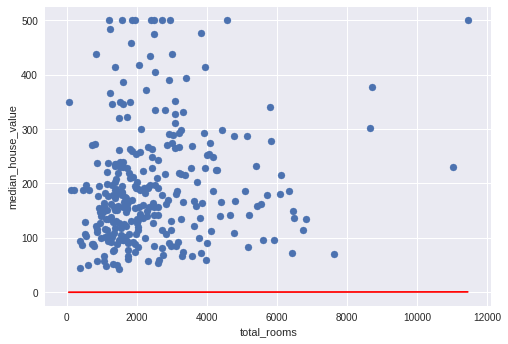

In [17]:
# Get the min and max total_rooms values.
x_0 = sample["total_rooms"].min()
x_1 = sample["total_rooms"].max()

# Retrieve the final weight and bias generated during training.
weight = linear_regressor.get_variable_value('linear/linear_model/total_rooms/weights')[0]
bias = linear_regressor.get_variable_value('linear/linear_model/bias_weights')

# Get the predicted median_house_values for the min and max total_rooms values.
y_0 = weight * x_0 + bias 
y_1 = weight * x_1 + bias

# Plot our regression line from (x_0, y_0) to (x_1, y_1).
plt.plot([x_0, x_1], [y_0, y_1], c='r')

# Label the graph axes.
plt.ylabel("median_house_value")
plt.xlabel("total_rooms")

# Plot a scatter plot from our data sample.
plt.scatter(sample["total_rooms"], sample["median_house_value"])

# Display graph.
plt.show()

This initial line looks way off.  See if you can look back at the summary stats and see the same information encoded there.

Together, these initial sanity checks suggest we may be able to find a much better line.

#### Tweak the Model Hyperparameters
For this exercise, we've put all the above code in a single function for convenience. You can call the function with different parameters to see the effect.

In this function, we'll proceed in 10 evenly divided periods so that we can observe the model improvement at each period.

For each period, we'll compute and graph training loss.  This may help you judge when a model is converged, or if it needs more iterations.

We'll also plot the feature weight and bias term values learned by the model over time.  This is another way to see how things converge.

In [0]:
def train_model(learning_rate, steps, batch_size, input_feature="total_rooms"):
  """Trains a linear regression model of one feature.
  
  Args:
    learning_rate: A `float`, the learning rate.
    steps: A non-zero `int`, the total number of training steps. A training step
      consists of a forward and backward pass using a single batch.
    batch_size: A non-zero `int`, the batch size.
    input_feature: A `string` specifying a column from `california_housing_dataframe`
      to use as input feature.
  """
  
  periods = 10
  steps_per_period = steps / periods

  my_feature = input_feature
  my_feature_data = california_housing_dataframe[[my_feature]]
  my_label = "median_house_value"
  targets = california_housing_dataframe[my_label]

  # Create feature columns.
  feature_columns = [tf.feature_column.numeric_column(my_feature)]
  
  # Create input functions.
  training_input_fn = lambda:my_input_fn(my_feature_data, targets, batch_size=batch_size)
  prediction_input_fn = lambda: my_input_fn(my_feature_data, targets, num_epochs=1, shuffle=False)
  
  # Create a linear regressor object.
  my_optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
  my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
  linear_regressor = tf.estimator.LinearRegressor(
      feature_columns=feature_columns,
      optimizer=my_optimizer
  )

  # Set up to plot the state of our model's line each period.
  plt.figure(figsize=(15, 6))
  plt.subplot(1, 2, 1)
  plt.title("Learned Line by Period")
  plt.ylabel(my_label)
  plt.xlabel(my_feature)
  sample = california_housing_dataframe.sample(n=300)
  plt.scatter(sample[my_feature], sample[my_label])
  colors = [cm.coolwarm(x) for x in np.linspace(-1, 1, periods)]

  # Train the model, but do so inside a loop so that we can periodically assess
  # loss metrics.
  print("Training model...")
  print("RMSE (on training data):")
  root_mean_squared_errors = []
  for period in range (0, periods):
    # Train the model, starting from the prior state.
    linear_regressor.train(
        input_fn=training_input_fn,
        steps=steps_per_period
    )
    # Take a break and compute predictions.
    predictions = linear_regressor.predict(input_fn=prediction_input_fn)
    predictions = np.array([item['predictions'][0] for item in predictions])
    
    # Compute loss.
    root_mean_squared_error = math.sqrt(
        metrics.mean_squared_error(predictions, targets))
    # Occasionally print the current loss.
    print("  period %02d : %0.2f" % (period, root_mean_squared_error))
    # Add the loss metrics from this period to our list.
    root_mean_squared_errors.append(root_mean_squared_error)
    # Finally, track the weights and biases over time.
    # Apply some math to ensure that the data and line are plotted neatly.
    y_extents = np.array([0, sample[my_label].max()])
    
    weight = linear_regressor.get_variable_value('linear/linear_model/%s/weights' % input_feature)[0]
    bias = linear_regressor.get_variable_value('linear/linear_model/bias_weights')

    x_extents = (y_extents - bias) / weight
    x_extents = np.maximum(np.minimum(x_extents,
                                      sample[my_feature].max()),
                           sample[my_feature].min())
    y_extents = weight * x_extents + bias
    plt.plot(x_extents, y_extents, color=colors[period]) 
  print("Model training finished.")

  # Output a graph of loss metrics over periods.
  plt.subplot(1, 2, 2)
  plt.ylabel('RMSE')
  plt.xlabel('Periods')
  plt.title("Root Mean Squared Error vs. Periods")
  plt.tight_layout()
  plt.plot(root_mean_squared_errors)

  # Output a table with calibration data.
  calibration_data = pd.DataFrame()
  calibration_data["predictions"] = pd.Series(predictions)
  calibration_data["targets"] = pd.Series(targets)
  display.display(calibration_data.describe())

  print("Final RMSE (on training data): %0.2f" % root_mean_squared_error)

#### Task 1:  Achieve an RMSE of 180 or Below

Tweak the model hyperparameters to improve loss and better match the target distribution.
If, after 5 minutes or so, you're having trouble beating a RMSE of 180, check the solution for a possible combination.

In [0]:
train_model(
    learning_rate=0.00001,
    steps=100,
    batch_size=1
)

##### Solution

Click below for one possible solution.

Training model...
RMSE (on training data):
  period 00 : 225.63
  period 01 : 214.42


KeyboardInterrupt: ignored

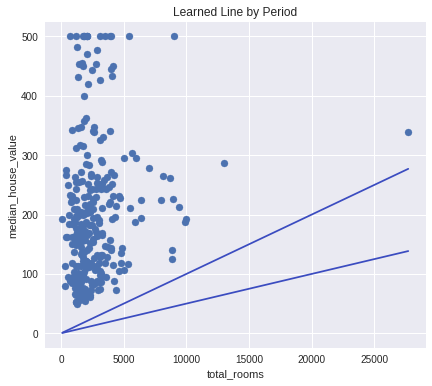

In [20]:
train_model(
    learning_rate=0.00002,
    steps=500,
    batch_size=5
)

This is just one possible configuration; there may be other combinations of settings that also give good results. Note that in general, this exercise isn't about finding the *one best* setting, but to help build your intutions about how tweaking the model configuration affects prediction quality.

##### Is There a Standard Heuristic for Model Tuning?


This is a commonly asked question. The short answer is that the effects of different hyperparameters are data dependent. So there are no hard-and-fast rules; you'll need to test on your data.

That said, here are a few rules of thumb that may help guide you:

 * Training error should steadily decrease, steeply at first, and should eventually plateau as training converges.
 * If the training has not converged, try running it for longer.
 * If the training error decreases too slowly, increasing the learning rate may help it decrease faster.
   * But sometimes the exact opposite may happen if the learning rate is too high.
 * If the training error varies wildly, try decreasing the learning rate.
   * Lower learning rate plus larger number of steps or larger batch size is often a good combination.
 * Very small batch sizes can also cause instability.  First try larger values like 100 or 1000, and decrease until you see degradation.

Again, never go strictly by these rules of thumb, because the effects are data dependent.  Always experiment and verify.

#### Task 2: Try a Different Feature

See if you can do any better by replacing the `total_rooms` feature with the `population` feature.

Don't take more than 5 minutes on this portion.

In [0]:
# YOUR CODE HERE

##### Solution

Click below for one possible solution.

In [0]:
%%time
train_model(
    learning_rate=0.00002,
    steps=1000,
    batch_size=5,
    input_feature="population"
)

### Enable TPU Support in Colab

![TPU](https://user-images.githubusercontent.com/58792/53053297-d14f2400-3455-11e9-836d-3857de1f4337.png)

## Keras

### Text classification with movie reviews (Project)

*Modified based on this tutorial: * https://research.google.com/seedbank/seed/classify_movie_reviews_using_tfkeras

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/keras/basic_text_classification"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/keras/basic_text_classification.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/keras/basic_text_classification.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>


This notebook classifies movie reviews as *positive* or *negative* using the text of the review. This is an example of *binary*—or two-class—classification, an important and widely applicable kind of machine learning problem. 

We'll use the [IMDB dataset](https://www.tensorflow.org/api_docs/python/tf/keras/datasets/imdb) that contains the text of 50,000 movie reviews from the [Internet Movie Database](https://www.imdb.com/). These are split into 25,000 reviews for training and 25,000 reviews for testing. The training and testing sets are *balanced*, meaning they contain an equal number of positive and negative reviews. 

This notebook uses [tf.keras](https://www.tensorflow.org/guide/keras), a high-level API to build and train models in TensorFlow. For a more advanced text classification tutorial using `tf.keras`, see the [MLCC Text Classification Guide](https://developers.google.com/machine-learning/guides/text-classification/).

In [22]:
from __future__ import absolute_import, division, print_function

import tensorflow as tf
from tensorflow import keras

import numpy as np

print(tf.__version__)

1.13.1


#### Ingest

##### Download the IMDB dataset

The IMDB dataset comes packaged with TensorFlow. It has already been preprocessed such that the reviews (sequences of words) have been converted to sequences of integers, where each integer represents a specific word in a dictionary.

The following code downloads the IMDB dataset to your machine (or uses a cached copy if you've already downloaded it):

In [23]:
imdb = keras.datasets.imdb

(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)

17465344/17464789 [==============================] - 0s 0us/step


The argument `num_words=10000` keeps the top 10,000 most frequently occurring words in the training data. The rare words are discarded to keep the size of the data manageable.

#### Explore the data (EDA)

Let's take a moment to understand the format of the data. The dataset comes preprocessed: each example is an array of integers representing the words of the movie review. Each label is an integer value of either 0 or 1, where 0 is a negative review, and 1 is a positive review.

In [24]:
print("Training entries: {}, labels: {}".format(len(train_data), len(train_labels)))

Training entries: 25000, labels: 25000


The text of reviews have been converted to integers, where each integer represents a specific word in a dictionary. Here's what the first review looks like:

In [25]:
print(train_data[0])

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]


Movie reviews may be different lengths. The below code shows the number of words in the first and second reviews. Since inputs to a neural network must be the same length, we'll need to resolve this later.

In [26]:
len(train_data[0]), len(train_data[1])

(218, 189)

##### Convert the integers back to words

It may be useful to know how to convert integers back to text. Here, we'll create a helper function to query a dictionary object that contains the integer to string mapping:

In [27]:
# A dictionary mapping words to an integer index
word_index = imdb.get_word_index()

# The first indices are reserved
word_index = {k:(v+3) for k,v in word_index.items()} 
word_index["<PAD>"] = 0
word_index["<START>"] = 1
word_index["<UNK>"] = 2  # unknown
word_index["<UNUSED>"] = 3

reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_review(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

1646592/1641221 [==============================] - 0s 0us/step


Now we can use the `decode_review` function to display the text for the first review:

In [28]:
decode_review(train_data[0])

"<START> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert <UNK> is an amazing actor and now the same being director <UNK> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for <UNK> and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also <UNK> to the two little boy's that played the <UNK> of norman and paul they were just brilliant children are often left out of the <UNK> list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for wh

##### Prepare the data

The reviews—the arrays of integers—must be converted to tensors before fed into the neural network. This conversion can be done a couple of ways:

* Convert the arrays into vectors of 0s and 1s indicating word occurrence, similar to a one-hot encoding. For example, the sequence  [3, 5] would become a 10,000-dimensional vector that is all zeros except for indices 3 and 5, which are ones. Then, make this the first layer in our network—a Dense layer—that can handle floating point vector data. This approach is memory intensive, though, requiring a `num_words * num_reviews` size matrix.

* Alternatively, we can pad the arrays so they all have the same length, then create an integer tensor of shape `max_length * num_reviews`. We can use an embedding layer capable of handling this shape as the first layer in our network.

In this tutorial, we will use the second approach. 

Since the movie reviews must be the same length, we will use the [pad_sequences](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/pad_sequences) function to standardize the lengths:

In [0]:
train_data = keras.preprocessing.sequence.pad_sequences(train_data,
                                                        value=word_index["<PAD>"],
                                                        padding='post',
                                                        maxlen=256)

test_data = keras.preprocessing.sequence.pad_sequences(test_data,
                                                       value=word_index["<PAD>"],
                                                       padding='post',
                                                       maxlen=256)

Let's look at the length of the examples now:

In [30]:
len(train_data[0]), len(train_data[1])

(256, 256)

And inspect the (now padded) first review:

In [31]:
print(train_data[0])

[   1   14   22   16   43  530  973 1622 1385   65  458 4468   66 3941
    4  173   36  256    5   25  100   43  838  112   50  670    2    9
   35  480  284    5  150    4  172  112  167    2  336  385   39    4
  172 4536 1111   17  546   38   13  447    4  192   50   16    6  147
 2025   19   14   22    4 1920 4613  469    4   22   71   87   12   16
   43  530   38   76   15   13 1247    4   22   17  515   17   12   16
  626   18    2    5   62  386   12    8  316    8  106    5    4 2223
 5244   16  480   66 3785   33    4  130   12   16   38  619    5   25
  124   51   36  135   48   25 1415   33    6   22   12  215   28   77
   52    5   14  407   16   82    2    8    4  107  117 5952   15  256
    4    2    7 3766    5  723   36   71   43  530  476   26  400  317
   46    7    4    2 1029   13  104   88    4  381   15  297   98   32
 2071   56   26  141    6  194 7486   18    4  226   22   21  134  476
   26  480    5  144   30 5535   18   51   36   28  224   92   25  104
    4 

#### Modeling

The neural network is created by stacking layers—this requires two main architectural decisions:

* How many layers to use in the model?
* How many *hidden units* to use for each layer?

In this example, the input data consists of an array of word-indices. The labels to predict are either 0 or 1. Let's build a model for this problem:

In [32]:
# input shape is the vocabulary count used for the movie reviews (10,000 words)
vocab_size = 10000

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, 16))
model.add(keras.layers.GlobalAveragePooling1D())
model.add(keras.layers.Dense(16, activation=tf.nn.relu))
model.add(keras.layers.Dense(1, activation=tf.nn.sigmoid))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160000    
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 16)                272       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 160,289
Trainable params: 160,289
Non-trainable params: 0
_________________________________________________________________


The layers are stacked sequentially to build the classifier:

1. The first layer is an `Embedding` layer. This layer takes the integer-encoded vocabulary and looks up the embedding vector for each word-index. These vectors are learned as the model trains. The vectors add a dimension to the output array. The resulting dimensions are: `(batch, sequence, embedding)`.
2. Next, a `GlobalAveragePooling1D` layer returns a fixed-length output vector for each example by averaging over the sequence dimension. This allows the model to handle input of variable length, in the simplest way possible.
3. This fixed-length output vector is piped through a fully-connected (`Dense`) layer with 16 hidden units.
4. The last layer is densely connected with a single output node. Using the `sigmoid` activation function, this value is a float between 0 and 1, representing a probability, or confidence level.

##### Hidden units



The above model has two intermediate or "hidden" layers, between the input and output. The number of outputs (units, nodes, or neurons) is the dimension of the representational space for the layer. In other words, the amount of freedom the network is allowed when learning an internal representation.

If a model has more hidden units (a higher-dimensional representation space), and/or more layers, then the network can learn more complex representations. However, it makes the network more computationally expensive and may lead to learning unwanted patterns—patterns that improve performance on training data but not on the test data. This is called *overfitting*, and we'll explore it later.

##### Loss function and optimizer

A model needs a loss function and an optimizer for training. Since this is a binary classification problem and the model outputs a probability (a single-unit layer with a sigmoid activation), we'll use the `binary_crossentropy` loss function. 

This isn't the only choice for a loss function, you could, for instance, choose `mean_squared_error`. But, generally, `binary_crossentropy` is better for dealing with probabilities—it measures the "distance" between probability distributions, or in our case, between the ground-truth distribution and the predictions.

Later, when we are exploring regression problems (say, to predict the price of a house), we will see how to use another loss function called mean squared error.

Now, configure the model to use an optimizer and a loss function:

In [0]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

##### Create a validation set

When training, we want to check the accuracy of the model on data it hasn't seen before. Create a *validation set* by setting apart 10,000 examples from the original training data. (Why not use the testing set now? Our goal is to develop and tune our model using only the training data, then use the test data just once to evaluate our accuracy).

In [0]:
x_val = train_data[:10000]
partial_x_train = train_data[10000:]

y_val = train_labels[:10000]
partial_y_train = train_labels[10000:]

##### Train the model

Train the model for 40 epochs in mini-batches of 512 samples. This is 40 iterations over all samples in the `x_train` and `y_train` tensors. While training, monitor the model's loss and accuracy on the 10,000 samples from the validation set:

In [35]:
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=40,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Train on 15000 samples, validate on 10000 samples
Epoch 1/40
15000/15000 [==============================] - 1s 38us/sample - loss: 0.6915 - acc: 0.5184 - val_loss: 0.6893 - val_acc: 0.5228
Epoch 2/40
15000/15000 [==============================] - 0s 19us/sample - loss: 0.6846 - acc: 0.6173 - val_loss: 0.6797 - val_acc: 0.6627
Epoch 3/40
15000/15000 [==============================] - 0s 19us/sample - loss: 0.6694 - acc: 0.7195 - val_loss: 0.6606 - val_acc: 0.7439
Epoch 4/40
15000/15000 [==============================] - 0s 18us/sample - loss: 0.6425 - acc: 0.7570 - val_loss: 0.6306 - val_acc: 0.7719
Epoch 5/40
15000/15000 [==============================] - 0s 20us/sample - loss: 0.6051 - acc: 0.7929 - val_loss: 0.5927 - val_acc: 0.7922
Epoch 6/40
15000/15000 [==============================] - 0s 18us/sample - loss: 0.5600 - acc: 0.8187 - val_loss: 0.5506 - val_acc: 0.8065
Epoch 7/40
15000/15000 [==============================] - 0s 18us/sample - loss: 0.5119 - acc: 0.8357 - val_loss: 0.

##### Evaluate the model

And let's see how the model performs. Two values will be returned. Loss (a number which represents our error, lower values are better), and accuracy.

In [36]:
results = model.evaluate(test_data, test_labels)

print(results)

25000/25000 [==============================] - 2s 62us/sample - loss: 0.3331 - acc: 0.8706
[0.3330800845146179, 0.87064]


This fairly naive approach achieves an accuracy of about 87%. With more advanced approaches, the model should get closer to 95%.

##### Create a graph of accuracy and loss over time

`model.fit()` returns a `History` object that contains a dictionary with everything that happened during training:

In [37]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])

There are four entries: one for each monitored metric during training and validation. We can use these to plot the training and validation loss for comparison, as well as the training and validation accuracy:

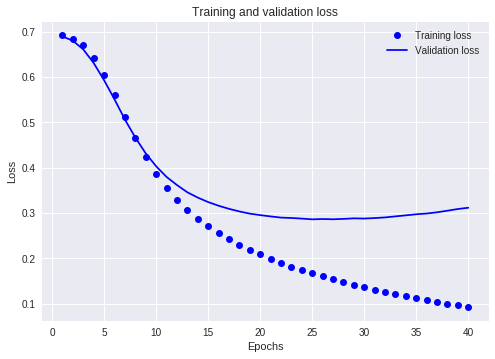

In [38]:
import matplotlib.pyplot as plt

acc = history_dict['acc']
val_acc = history_dict['val_acc']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

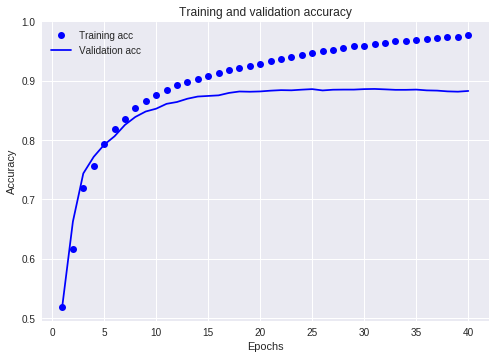

In [39]:
plt.clf()   # clear figure

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


In this plot, the dots represent the training loss and accuracy, and the solid lines are the validation loss and accuracy.

Notice the training loss *decreases* with each epoch and the training accuracy *increases* with each epoch. This is expected when using a gradient descent optimization—it should minimize the desired quantity on every iteration.

This isn't the case for the validation loss and accuracy—they seem to peak after about twenty epochs. This is an example of overfitting: the model performs better on the training data than it does on data it has never seen before. After this point, the model over-optimizes and learns representations *specific* to the training data that do not *generalize* to test data.

For this particular case, we could prevent overfitting by simply stopping the training after twenty or so epochs. Later, you'll see how to do this automatically with a callback.

## Ludwig (Open Source AutoML)

**Github Project URL**:  https://uber.github.io/ludwig/

![alt text](https://user-images.githubusercontent.com/58792/52920000-f78d8c00-32bc-11e9-8e5e-adf53f1b8a37.png)

### Install Ludwig

In [40]:
!pip install --upgrade numpy #must restart colab runtime
!pip install --upgrade scikit-image
!pip install -q ludwig
!python -m spacy download en 

    100% |████████████████████████████████| 17.3MB 2.2MB/s 
featuretools 0.4.1 has requirement pandas>=0.23.0, but you'll have pandas 0.22.0 which is incompatible.
albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.8 which is incompatible.
  Found existing installation: numpy 1.14.6
    Uninstalling numpy-1.14.6:
      Successfully uninstalled numpy-1.14.6


    100% |████████████████████████████████| 25.3MB 833kB/s 
    100% |████████████████████████████████| 2.0MB 10.1MB/s 
    100% |████████████████████████████████| 706kB 22.9MB/s 
featuretools 0.4.1 has requirement pandas>=0.23.0, but you'll have pandas 0.22.0 which is incompatible.
albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.8 which is incompatible.
  Found existing installation: Pillow 4.1.1
    Uninstalling Pillow-4.1.1:
      Successfully uninstalled Pillow-4.1.1
  Found existing installation: dask 0.20.2
    Uninstalling dask-0.20.2:
      Successfully uninstalled dask-0.20.2
  Found existing installation: scikit-image 0.13.1
    Uninstalling scikit-image-0.13.1:
      Successfully uninstalled scikit-image-0.13.1


    100% |████████████████████████████████| 122kB 4.6MB/s 

    Linking successful
    /usr/local/lib/python3.6/dist-packages/en_core_web_sm -->
    /usr/local/lib/python3.6/dist-packages/spacy/data/en

    You can now load the model via spacy.load('en')



### Basic Ideas

* **Training Models**
* **Prediction (Inference)**
* **Datatypes**
 - binary
 - numerical
 - category
 - set
 - bag
 - sequence
 - text
 - timeseries
 - image



### Classification of Book Title Categories (Project)

In [1]:
!wget https://raw.githubusercontent.com/uchidalab/book-dataset/master/Task1/book30-listing-train.csv
!wget https://raw.githubusercontent.com/noahgift/recommendations/master/model_definition.yaml

--2019-03-06 18:33:48--  https://raw.githubusercontent.com/uchidalab/book-dataset/master/Task1/book30-listing-train.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9728786 (9.3M) [text/plain]
Saving to: ‘book30-listing-train.csv’

book30-listing-trai 100%[===================>]   9.28M  --.-KB/s    in 0.1s    

2019-03-06 18:33:48 (86.7 MB/s) - ‘book30-listing-train.csv’ saved [9728786/9728786]

--2019-03-06 18:33:48--  https://raw.githubusercontent.com/noahgift/recommendations/master/model_definition.yaml
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response..

#### Ingest

In [2]:
import pandas as pd
df = pd.read_csv("https://media.githubusercontent.com/media/noahgift/recommendations/master/data/book30-listing-train-with-headers.csv")
df = df.drop("Unnamed: 0", axis=1)
df.head()

,ASIN,FILENAME,IMAGE URL,TITLE,AUTHOR,CATEGORYID,CATEGORY
0,1404803335,1404803335.jpg,http://ecx.images-amazon.com/images/I/51UJnL3T...,"Magnets: Pulling Together, Pushing Apart (Amaz...",Natalie M. Rosinsky,4,Children's Books
1,1446276082,1446276082.jpg,http://ecx.images-amazon.com/images/I/51MGUKhk...,Energy Security (SAGE Library of International...,NaN,10,Engineering & Transportation
2,1491522666,1491522666.jpg,http://ecx.images-amazon.com/images/I/51qKvjsi...,An Amish Gathering: Life in Lancaster County,Beth Wiseman,9,Christian Books & Bibles
3,970096410,0970096410.jpg,http://ecx.images-amazon.com/images/I/51qoUENb...,City of Rocks Idaho: A Climber's Guide (Region...,Dave Bingham,26,Sports & Outdoors
4,8436808053,8436808053.jpg,http://ecx.images-amazon.com/images/I/41aDW5pz...,"Como vencer el insomnio. Tecnicas, reglas y co...",Choliz Montanes,11,"Health, Fitness & Dieting"


In [0]:
df.to_csv("book30-listing-train-with-headers.csv")

#### EDA

**Columns**

In [4]:
df.columns

Index(['ASIN', 'FILENAME', 'IMAGE URL', 'TITLE', 'AUTHOR', 'CATEGORYID',
       'CATEGORY'],
      dtype='object')

**Shape**

In [5]:
df.shape

(51299, 7)

#### Training w/Ludwig

In [6]:
!head book30-listing-train-with-headers.csv

,ASIN,FILENAME,IMAGE URL,TITLE,AUTHOR,CATEGORYID,CATEGORY
0,1404803335,1404803335.jpg,http://ecx.images-amazon.com/images/I/51UJnL3Tx6L.jpg,"Magnets: Pulling Together, Pushing Apart (Amazing Science)",Natalie M. Rosinsky,4,Children's Books
1,1446276082,1446276082.jpg,http://ecx.images-amazon.com/images/I/51MGUKhkyhL.jpg,Energy Security (SAGE Library of International Security),,10,Engineering & Transportation
2,1491522666,1491522666.jpg,http://ecx.images-amazon.com/images/I/51qKvjsi3ML.jpg,An Amish Gathering: Life in Lancaster County,Beth Wiseman,9,Christian Books & Bibles
3,970096410,0970096410.jpg,http://ecx.images-amazon.com/images/I/51qoUENb1CL.jpg,City of Rocks Idaho: A Climber's Guide (Regional Rock Climbing Series),Dave Bingham,26,Sports & Outdoors
4,8436808053,8436808053.jpg,http://ecx.images-amazon.com/images/I/41aDW5pzZBL.jpg,"Como vencer el insomnio. Tecnicas, reglas y consejos practicos para dormir mejor (BIBLIOTECA PRACTICA) (Spanish Edition)",Choliz Montanes,11,"Health, Fi

In [7]:
!cat model_definition.yaml

input_features:
    -
        name: TITLE
        type: text
        encoder: parallel_cnn
        level: word

output_features:
    -
        name: CATEGORY
        type: category

In [8]:
!ludwig experiment --data_csv book30-listing-train-with-headers.csv --model_definition_file model_definition.yaml


 _         _        _      
| |_  _ __| |_ __ _(_)__ _ 
| | || / _` \ V  V / / _` |
|_|\_,_\__,_|\_/\_/|_\__, |
                     |___/ 
ludwig v0.1.0 - Experiment

Experiment name: experiment
Model name: run
Output path: results/experiment_run_0

ludwig_version: '0.1.0'
command: ('/usr/local/bin/ludwig experiment --data_csv '
 'book30-listing-train-with-headers.csv --model_definition_file '
 'model_definition.yaml')
dataset_type: 'book30-listing-train-with-headers.csv'
model_definition: {   'combiner': {'type': 'concat'},
    'input_features': [   {   'encoder': 'parallel_cnn',
                              'level': 'word',
                              'name': 'TITLE',
                              'tied_weights': None,
                              'type': 'text'}],
    'output_features': [   {   'dependencies': [],
                               'loss': {   'class_distance_temperature': 0,
                                           'class_weights': 1,
                           

## GCP AutoML






![GCP AutoML](https://user-images.githubusercontent.com/58792/45260264-134c4800-b397-11e8-9832-fd56a8eeaa3c.png)


**[GCP AutoML Products](https://cloud.google.com/automl/)**

*  [AutoML Vision](https://cloud.google.com/vision/automl/docs/)
*  [AutoML Natural Language](https://cloud.google.com/natural-language/automl/docs/)
*  [AutoML Translation](https://cloud.google.com/translate/automl/docs/)


### GCP AutoML Demo


Training to recognize flowers

![upload_data](https://user-images.githubusercontent.com/58792/45438280-94dbf880-b66b-11e8-850d-e7d2a32c45c8.png)

![train](https://user-images.githubusercontent.com/58792/45438281-94dbf880-b66b-11e8-9951-80202c581b0c.png)

![predict](https://user-images.githubusercontent.com/58792/45439236-1fbdf280-b66e-11e8-9f51-d92d26a63c64.png)

## GCP Vision API

https://cloud.google.com/vision/

![Vision API](https://cloud.google.com/images/products/vision/image-search.svg)

* [Step 1:  Enable API](https://cloud.google.com/vision/docs/before-you-begin)

### Load Google Credentials with GDrive


In [9]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [10]:
import os;os.listdir("/content/gdrive/My Drive/awsml")

['kaggle.json', 'credentials', 'config', 'cloudai-7ab42a4d8a43.json']

In [11]:
!ls -la /content/gdrive/My\ Drive/awsml

total 4
-rw------- 1 root root 2305 Feb 22 23:47 cloudai-7ab42a4d8a43.json
-rw------- 1 root root   43 Nov 22 00:05 config
-rw------- 1 root root  117 Nov 22 00:01 credentials
-rw------- 1 root root   64 Nov 21 22:24 kaggle.json


Install cloud vision Api

In [12]:
!export GOOGLE_APPLICATION_CREDENTIALS="/content/gdrive/My\ Drive/awsml/cloudai-7ab42a4d8a43.json"
!gcloud auth activate-service-account --key-file /content/gdrive/My\ Drive/awsml/cloudai-7ab42a4d8a43.json
!pip install --upgrade -q google-cloud-vision

Activated service account credentials for: [pragai@cloudai-194723.iam.gserviceaccount.com]
    100% |████████████████████████████████| 389kB 8.5MB/s 


In [13]:
import io
import os

os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="/content/gdrive/My Drive/awsml/cloudai-7ab42a4d8a43.json"

# Imports the Google Cloud client library
from google.cloud import vision
from google.cloud.vision import types

# Instantiates a client
client = vision.ImageAnnotatorClient()

# The name of the image file to annotate
file_name = 'wakeupcat.jpg'

# Loads the image into memory
with io.open(file_name, 'rb') as image_file:
    content = image_file.read()

image = types.Image(content=content)

# Performs label detection on the image file
response = client.label_detection(image=image)
labels = response.label_annotations

print('Labels:')
for label in labels:
    print(label.description)

Labels:
Cat
Whiskers
Small to medium-sized cats
Felidae
Fur
Nose
Ear
Snout
Carnivore
Eye


## References




*   [Google Machine Learning Crash Course](https://developers.google.com/machine-learning/crash-course/)

